# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

### Setup

In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import geomstats.backend as gs

gs.random.seed(2021)

INFO: Using numpy backend


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [2]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f"Total number of cells : {len(cells)}")

Total number of cells : 650


The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [3]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


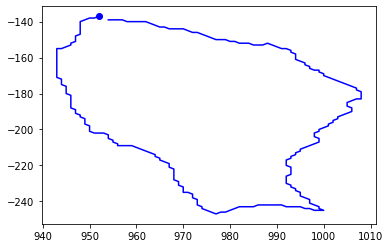

In [4]:
cell_idx = 1
plt.plot(cells[cell_idx][:, 0], cells[cell_idx][:, 1], "blue")
plt.plot(cells[cell_idx][0, 0], cells[cell_idx][0, 1], "blue", marker="o");

The size of each class is displayed below:

In [5]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


The above code also created a dictionnary `ds`, that contains the cell boundaries data sorted by `treatment` and cell `line`. To access all the cells corresponding to a given treatment and a given cell line, we use the syntax `ds[treatment][line]` as in the following code that computes the number of cells in the cytd-dlm8 class.

In [6]:
len(ds["cytd"]["dlm8"])

82

We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [7]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [8]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


N_SAMPLING_POINTS = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

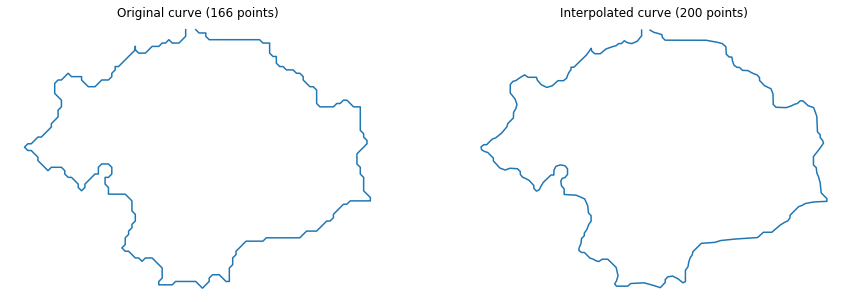

In [9]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, N_SAMPLING_POINTS)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({N_SAMPLING_POINTS} points)")
plt.axis("off")

plt.savefig("interpolation.svg")

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [10]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, N_SAMPLING_POINTS)
)

For each key treatment-control, we check that the number of sampling points is the one expected, i.e. `N_SAMPLING_POINTS`:

In [11]:
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

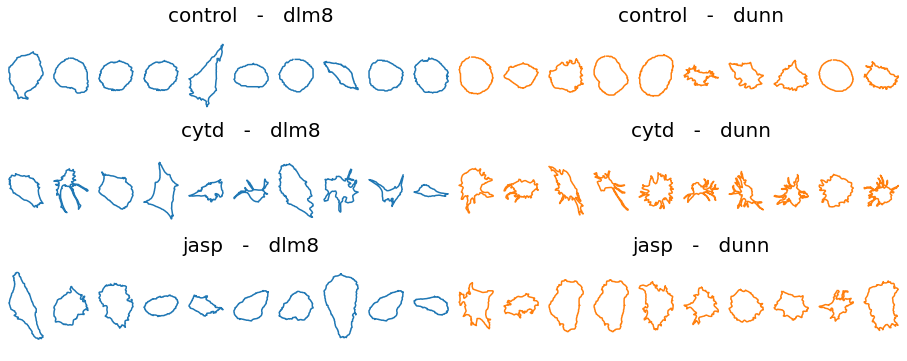

In [12]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for treatment in TREATMENTS:
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(int((line == "dunn"))))
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
plt.savefig("cancer_cell_sample.svg")

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate samples in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [13]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. These operations will be performed by leveraging the geometry of the so-called Kendall preshape spaces and specifically its method `PRESHAPE_SPACE.projection`, as shown below. Details on Kendall shape spaces can be found in the [module implementing them](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/pre_shape.py) or the notebooks using them. 

Additionally, since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). This exhaustive search is implemented in the function `exhaustive_align` below.

In [14]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=N_SAMPLING_POINTS)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_metric


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift) % nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=reparametrized, base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(
            gs.array(aligned) - gs.array(base_curve)
        )
    shift_min = gs.argmin(distances)
    reparametrized_min = [
        curve[(i + shift_min) % nb_sampling] for i in range(nb_sampling)
    ]
    aligned_curve = PRESHAPE_SPACE.align(
        point=reparametrized_min, base_point=base_curve
    )
    return aligned_curve

We perform the pre-shape projection and the exhaustive alignment of the cells against the base curve, which is chosen to be the first cell curve of the dataset, called `BASE_CURVE`. 

Both the projection and the alignment make use of our auxiliary function `apply_func_to_ds`, which finally outputs a dataset of cell curves organized within a dictionnary called `ds_align`.

In [15]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

ds_proj = apply_func_to_ds(ds_proc, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)
(204, 200, 2)


We visually evaluate that methods perform correctly, by plotting the results of the projection and the alignment through the following code.

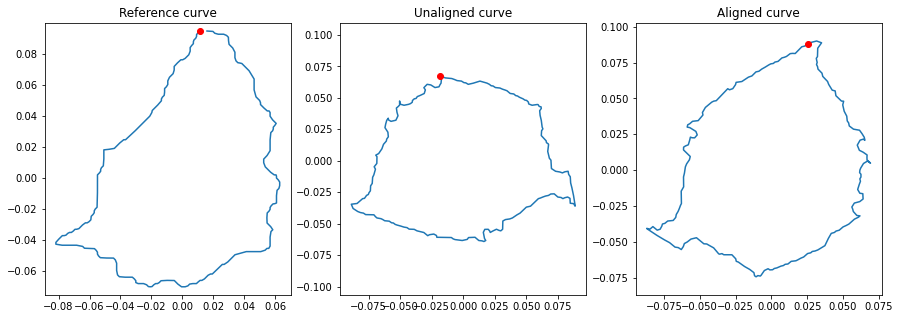

In [16]:
i_rand = gs.random.randint(n_cells_df.loc["control"]["dunn"])
unaligned_cell = ds_proj["control"]["dunn"][i_rand]
aligned_cell = ds_align["control"]["dunn"][i_rand]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig("alignment.svg")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Geodesic Trajectory Joining Two Cell Shapes

Using *Geomstats*, we can compute geodesics between discrete curves with respect to the elastic metric [(SKJJ2010)](#References). In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells.

This code chooses one control cell from dunn and one control cell from dlm8 (Run the block again to choose other cells).

In [17]:
i_start_rand = gs.random.randint(len(ds_proj["control"]["dunn"]))
i_end_rand = gs.random.randint(len(ds_proj["control"]["dlm8"]))

cell_start = ds_align["control"]["dunn"][i_start_rand]
cell_end = ds_align["control"]["dlm8"][i_end_rand]

print(i_start_rand, i_end_rand)

57 0


We import the manifold of discrete curves, and the metric on it.

We compute a geodesic between the two curves selected above, and sample points along this geodesic (where a given point represents a cell) at some input `times`.

In [18]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.square_root_velocity_metric

geodesic = SRV_METRIC.geodesic(initial_curve=cell_start, end_curve=cell_end)

n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
geod_points = geodesic(times)

This code shows the geodesic, which is a trajectory in the space of curves, between the two selected cells.

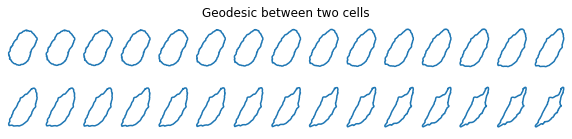

In [19]:
fig = plt.figure(figsize=(10, 2))
plt.title("Geodesic between two cells")
plt.axis("off")

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times // 2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis("equal")
    plt.axis("off")
plt.savefig("geodesic_light_blue.svg")

The following code is a different visualization of the same geodesic.

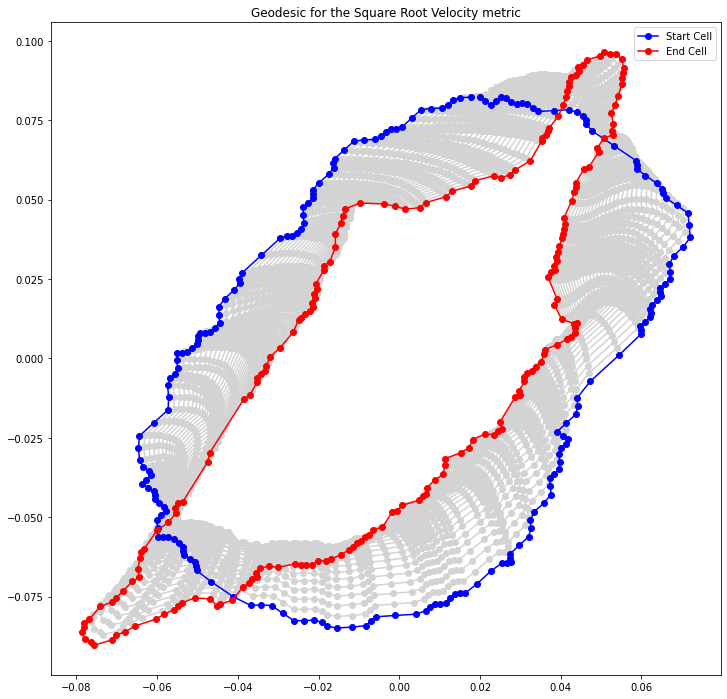

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(12, 12))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-", color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b", label="Start Cell")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r", label="End Cell")

plt.title("Geodesic for the Square Root Velocity metric")
plt.legend()
plt.show()
plt.savefig("geodesic_blue_red.svg");

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [21]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])

cell_shapes = gs.array(cell_shapes_list)
print(cell_shapes.shape)

(650, 200, 2)


We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

We need to use the `point_type="matrix"` because one cell shape is represented by an array of shape n_sampling_points x 2, which is a matrix.

We only use the first 500 cells of the dataset, for numerical reasons: the FrechetMean is failing upon incorporating shapes from the remainder of the dataset.

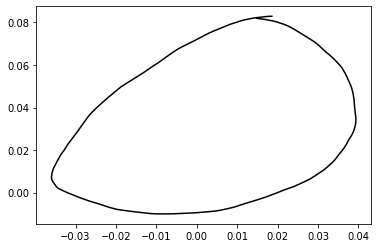

In [22]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(metric=SRV_METRIC, point_type="matrix", method="default")
mean.fit(cell_shapes[:500])

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

The mean cell shape does indeed look like a cell shape. We note that there is a discontinuity in the cell because we have modeled the curves' boundaries as open curves. The space of curves considered here is also the space of (open) discrete curves.

Unfortunately, sometimes there could be Nans in the values of the mean shape. If this is the case, this code removes them manually, and re-interpolate the mean shape.

In [23]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = interpolate(mean_estimate_clean, N_SAMPLING_POINTS)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(200, 2)
0
(200, 2)


We plot the mean cell shape, superimposed on top of the dataset of cells (displayed in light grey underneath).

(650, 200, 2)


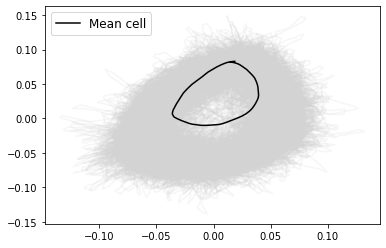

In [24]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_clean[:, 0], mean_estimate_clean[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We see that the scale and alignment of the mean shape is slightly off. This makes sense, as our computations have quotiented out scale and alignment. We correct it manually.

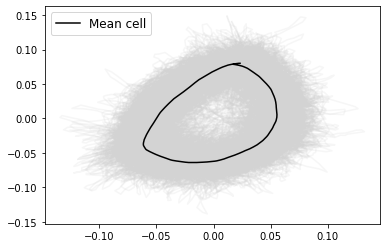

In [25]:
mean_estimate_aligned = 1.55 * (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)

plt.plot(
    mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

We visualize the same plot, but now:
- closing the mean shape that becomes a closed curve
- plotting underneath the mean shape the distribution of the sampling points of all the curves of the dataset, through a kernel density estimation.

Visualizing the full datasets of 640+ cells takes a long time. Therefore, we also select only 200 cells, randomly, within the dataset.

In [26]:
mean_estimate_aligned_bis = gs.vstack(
    [mean_estimate_aligned[4:], mean_estimate_aligned[-1]]
)

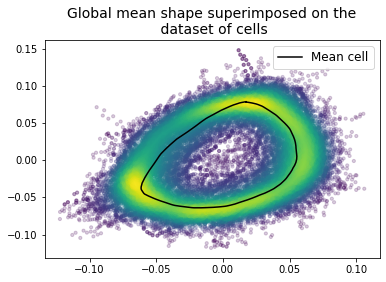

In [27]:
from scipy.stats import gaussian_kde

cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(
    mean_estimate_aligned_bis[:, 0],
    mean_estimate_aligned_bis[:, 1],
    "black",
    label="Mean cell",
)
plt.legend(fontsize=12)
plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14)

plt.savefig("global_mean_shape.svg")

This plot allows to verify that the mean shape that has been computed makes sense.

# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their treatment and cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [28]:
dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: SRV_METRIC.dist(x, mean_estimate_aligned)
)

dists_to_global_mean_list = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list.extend(dists_to_global_mean[t][l])

As an example, the following code shows the 5 first distances of cell shapes.

In [29]:
dists_to_global_mean_list[:5]

[0.4933959475000852,
 0.4581603474862174,
 0.39749591971043446,
 0.4103200985741522,
 0.3695051182290453]

We compute a few statistics about this list of distances to the global mean shape, checking:
- that there are no NaNs,
- what are the values of the min and max distances.

In [30]:
gs.where(gs.isnan(dists_to_global_mean_list))

(array([], dtype=int64),)

In [31]:
min_dists = min(dists_to_global_mean_list)
max_dists = max(dists_to_global_mean_list)
print(min_dists, max_dists)

0.32767936217402055 1.265422921180121


In [32]:
xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)

We plot the distances to the mean global shape, by splitting them into the three treatment groups.

In [33]:
from scipy import stats

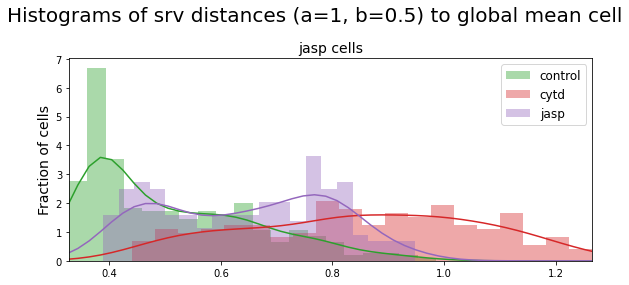

In [34]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for i, treatment in enumerate(TREATMENTS):
    distances = []
    for j, line in enumerate(LINES):
        distances.extend(
            dists_to_global_mean[treatment][line][
                ~gs.isnan(dists_to_global_mean[treatment][line])
            ]
        )
    color = "C" + str(2 + i)
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=treatment)
    kde = stats.gaussian_kde(distances)
    axs.plot(xx, kde(xx), color=color)
    axs.set_xlim((min_dists, max_dists))
    axs.legend(fontsize=12)

    axs.set_title(f"{treatment} cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of srv distances (a=1, b=0.5) to global mean cell", fontsize=20)
plt.savefig("dist_to_global_mean_per_treatment2.svg")

We observe that each of these distributions seems to be bimodal, which might corresponds to the fact that we have actually two cell lines per treatment. We verify this hypothesis.

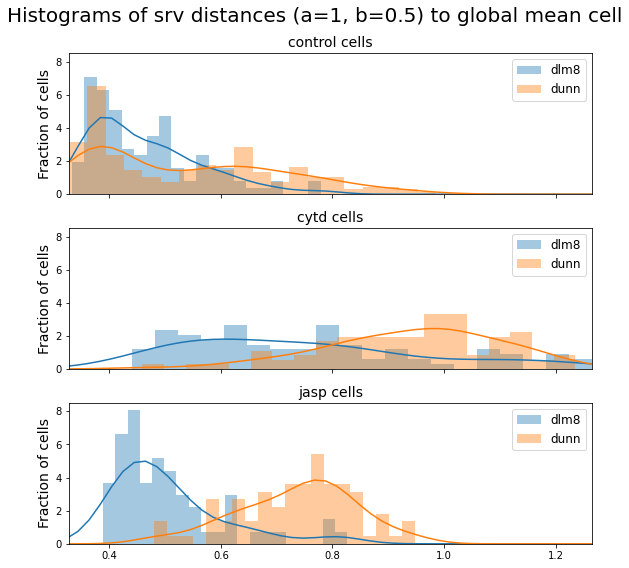

In [35]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

axs[0].set_xlim((min_dists, max_dists))
for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = dists_to_global_mean[treatment][line][
            ~gs.isnan(dists_to_global_mean[treatment][line])
        ]
        color = f"C{j}"
        axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=line
        )
        kde = stats.gaussian_kde(distances)
        axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of srv distances (a=1, b=0.5) to global mean cell", fontsize=20)
plt.savefig("dist_to_global_mean_per_class2.svg")

For the treatments jasp and cytd, it seems indeed that the bimodality is explained by the two cell lines.

In order to better understand which cells correspond to which distance, on the above plot, we run the following code. This code find a given number of quantiles within the distance's histogram, and plots the corresponding cell, for each treatment and each cell line.

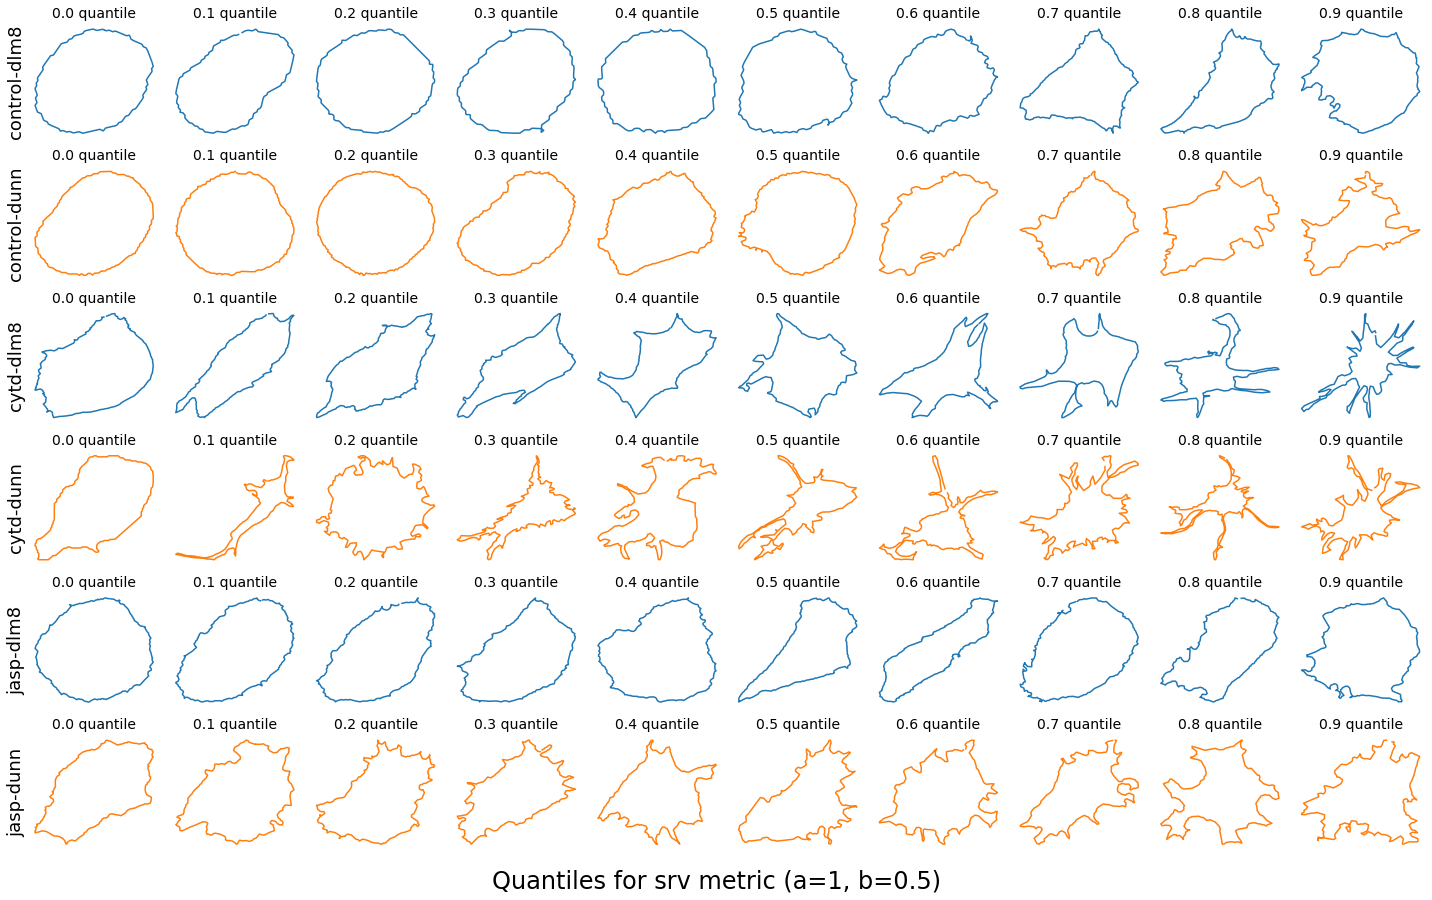

In [36]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(TREATMENTS) * len(LINES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(LINES) * len(TREATMENTS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        dists_list = dists_to_global_mean[treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand() for d in dists_list]
        cells_list = list(ds_align[treatment][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{treatment}-{line}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for srv metric (a=1, b=0.5)", y=-0.01, fontsize=24)
plt.savefig("quantiles.svg")

# Changing the Metric on the Space of Cell Shapes

What happens if we change the metric on the space of cell shapes? E.g. if we penalize bending more, such that paths (of cell shapes) that bend the boundary of the cells have a longer "length" in th shape space.

We define the elastic metric, as a generalization of the srv metric --- with two hyperparameters a and b that penalize bending and stretching. The case a=1 and b=1/2 corresponds to the srv metric we have used until now.

In [37]:
from geomstats.geometry.discrete_curves import ElasticCurves, ElasticMetric

a = 3
b = 1
ELASTIC_CURVES = ElasticCurves(a=a, b=b)
ELASTIC_METRIC = ELASTIC_CURVES.elastic_metric

In [38]:
elastic_dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: ELASTIC_METRIC.dist(x, mean_estimate_aligned)
)

elastic_dists_to_global_mean_list = []
for t in TREATMENTS:
    for l in LINES:
        elastic_dists_to_global_mean_list.extend(elastic_dists_to_global_mean[t][l])

In [39]:
elastic_min_dists = min(elastic_dists_to_global_mean_list)
elastic_max_dists = max(elastic_dists_to_global_mean_list)
print(elastic_min_dists, elastic_max_dists)
elastic_xx = gs.linspace(gs.floor(elastic_min_dists), gs.ceil(elastic_max_dists), 100)

0.8639906334939036 3.0954972636439364


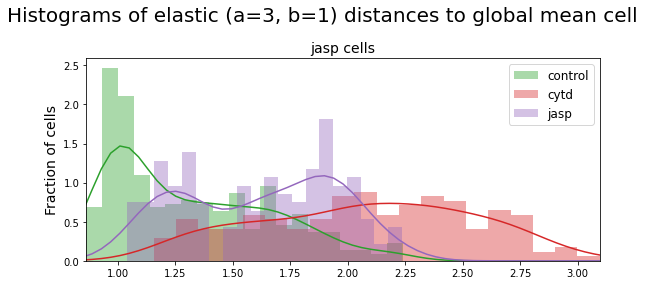

In [40]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))

for i, treatment in enumerate(TREATMENTS):
    distances = []
    for j, line in enumerate(LINES):
        distances.extend(
            elastic_dists_to_global_mean[treatment][line][
                ~gs.isnan(elastic_dists_to_global_mean[treatment][line])
            ]
        )
    color = "C" + str(2 + i)
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=treatment)
    kde = stats.gaussian_kde(distances)
    axs.plot(elastic_xx, kde(elastic_xx), color=color)
    axs.set_xlim((elastic_min_dists, elastic_max_dists))
    axs.legend(fontsize=12)

    axs.set_title(f"{treatment} cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle(f"Histograms of elastic (a={a}, b={b}) distances to global mean cell", fontsize=20)
plt.savefig(f"dist_to_global_mean_per_treatment2_a{a}_b{b}.svg")

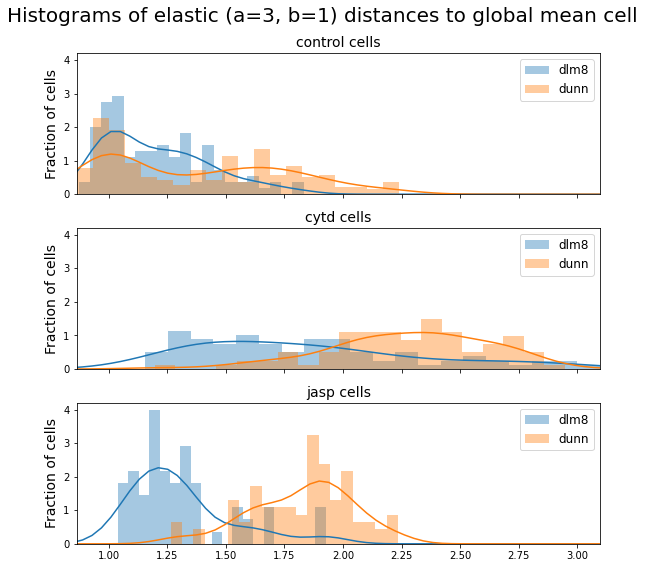

In [41]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

axs[0].set_xlim((elastic_min_dists, elastic_max_dists))
for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = elastic_dists_to_global_mean[treatment][line][
            ~gs.isnan(elastic_dists_to_global_mean[treatment][line])
        ]
        color = f"C{j}"
        axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=line
        )
        kde = stats.gaussian_kde(distances)
        axs[i].plot(elastic_xx, kde(elastic_xx), color=color)

    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle(f"Histograms of elastic (a={a}, b={b}) distances to global mean cell", fontsize=20)
plt.savefig(f"dist_to_global_mean_per_class2_a{a}_b{b}.svg")

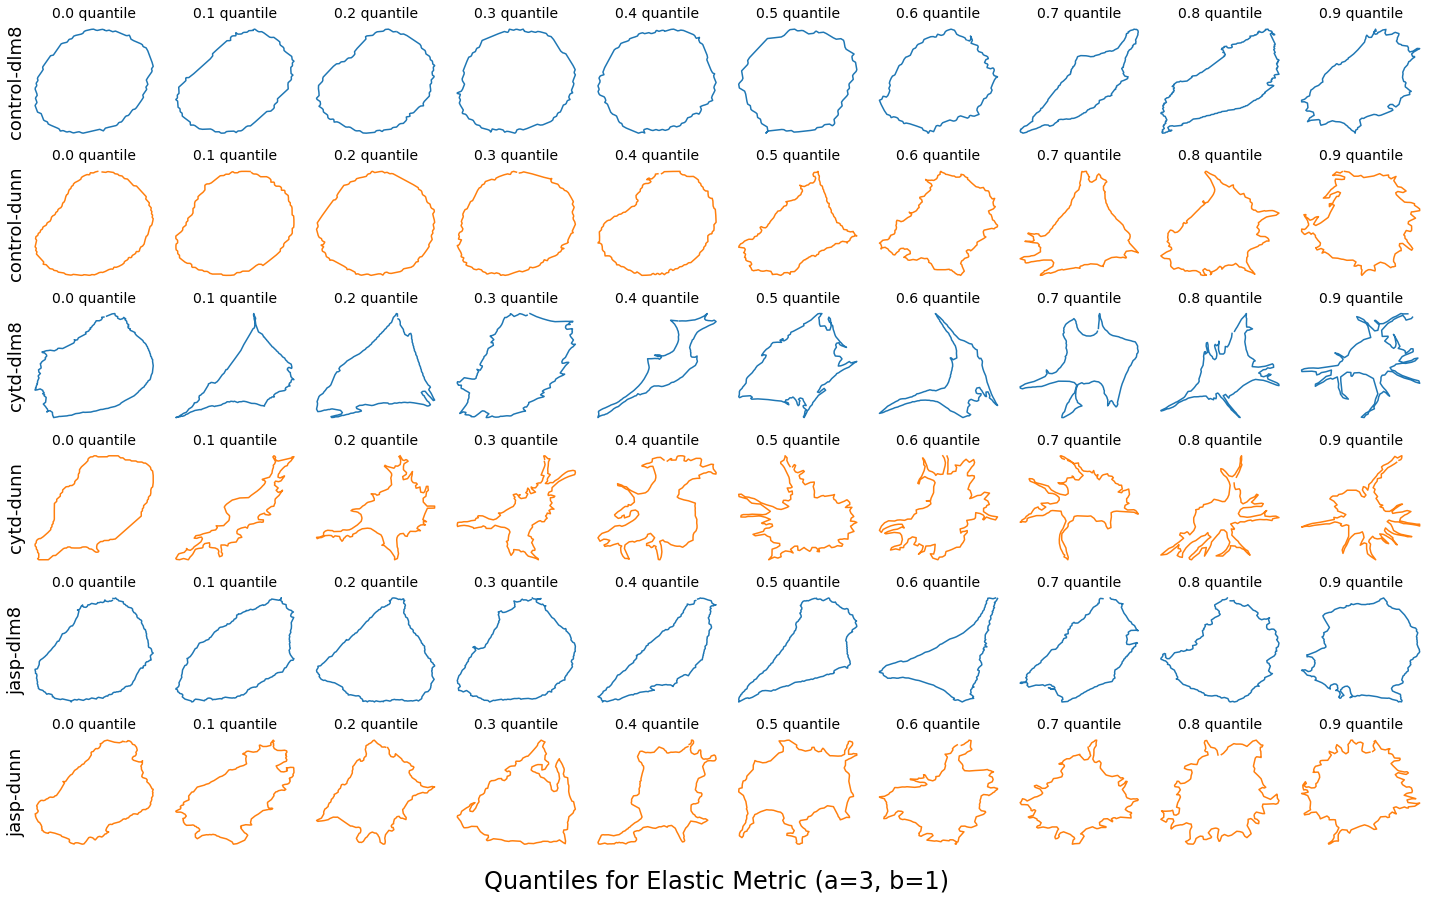

In [42]:
n_quantiles = 10
fig, axes = plt.subplots(
    nrows=len(TREATMENTS) * len(LINES),
    ncols=n_quantiles,
    figsize=(20, 2 * len(LINES) * len(TREATMENTS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        elastic_dists_list = elastic_dists_to_global_mean[treatment][line]
        elastic_dists_list = [d + 0.0001 * gs.random.rand() for d in elastic_dists_list]
        cells_list = list(ds_align[treatment][line])
        assert len(elastic_dists_list) == len(elastic_dists_list)
        n_cells = len(elastic_dists_list)

        zipped_lists = zip(elastic_dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2 * i + j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{treatment}-{line}", rotation=90, fontsize=18)
plt.tight_layout()
plt.suptitle(f"Quantiles for Elastic Metric (a={a}, b={b})", y=-0.01, fontsize=24)
plt.savefig(f"elastic_quantiles_a{a}_b{b}.svg")

# Hypothesis Testing on Equality of Means

The histograms above qualitatively show that the subgroups of treatments and cell lines have different mean distances to the global mean shape: the averages of the histograms above differ.

To evaluate this fact quantitatively, we perform a hypothesis test. Specifically, we test the null hypothesis that two subgroups are at the same distance to the mean global shape. 

This is realized through a t-test with unequal variances. We choose a significance level of 0.01. The p-values that are lower than this significance level, after correction for multiple hypothesis testing, correspond to the tests that reject the null hypothesis and thus demonstrate an inequality of means at 0.01.

In [43]:
import scipy

In [44]:
line_1, line_2 = LINES

print(f"\n --- Test equality of means: {line_1} vs {line_2}")
dists_1 = []
for treatment_1 in TREATMENTS:
    dists_1.extend(dists_to_global_mean[treatment_1][line_1])
dists_1 = gs.array(dists_1)

dists_2 = []
for treatment_2 in TREATMENTS:
    dists_2.extend(dists_to_global_mean[treatment_2][line_2])
dist_2 = gs.array(dists_2)

display(scipy.stats.ttest_ind(dists_1, dists_2, equal_var=False))


 --- Test equality of means: dlm8 vs dunn


Ttest_indResult(statistic=-7.1196419270836255, pvalue=3.095402159409669e-12)

In [45]:
count = 0

from itertools import combinations

for two_treatments in combinations(TREATMENTS, 2):
    treatment_1, treatment_2 = two_treatments

    print(f"\n --- Test equality of means: {treatment_1} vs {treatment_2}")
    dists_1 = []
    for line_1 in LINES:
        dists_1.extend(dists_to_global_mean[treatment_1][line_1])
    dists_1 = gs.array(dists_1)

    dists_2 = []
    for line_2 in LINES:
        dists_2.extend(dists_to_global_mean[treatment_2][line_2])
    dist_2 = gs.array(dists_2)

    display(scipy.stats.ttest_ind(dists_1, dists_2, equal_var=False))
    count += 1
print(
    f"!! Correct for multiple hypothesis testing with Bonferroni correction,"
    f" by multiplying the p-values by {count} "
)


 --- Test equality of means: control vs cytd


Ttest_indResult(statistic=-18.910331168398848, pvalue=1.5942047693179265e-51)


 --- Test equality of means: control vs jasp


Ttest_indResult(statistic=-9.029282700140124, pvalue=2.0182138940342863e-17)


 --- Test equality of means: cytd vs jasp


Ttest_indResult(statistic=10.293250508487523, pvalue=1.2621209911041894e-21)

!! Correct for multiple hypothesis testing with Bonferroni correction, by multiplying the p-values by 3 


In [46]:
TREATMENT_LINE_CLASSES = set([(t, l) for t in TREATMENTS for l in LINES])

In [47]:
count = 0

for two_classes in combinations(TREATMENT_LINE_CLASSES, 2):
    class_1, class_2 = two_classes
    treatment_1, line_1 = class_1
    treatment_2, line_2 = class_2
    print(
        f"\n --- Test equality of means: {treatment_1}-{line_1} vs {treatment_2}-{line_2}"
    )
    display(
        scipy.stats.ttest_ind(
            dists_to_global_mean[treatment_1][line_1],
            dists_to_global_mean[treatment_2][line_2],
            equal_var=False,
        )
    )
    count += 1
print(
    f"!! Correct for multiple hypothesis testing with Bonferroni correction,"
    f" by multiplying the p-values by {count} "
)


 --- Test equality of means: jasp-dunn vs control-dunn


Ttest_indResult(statistic=12.505967524150536, pvalue=1.2633229491332504e-28)


 --- Test equality of means: jasp-dunn vs cytd-dunn


Ttest_indResult(statistic=-10.620144035734329, pvalue=2.6930383406540247e-20)


 --- Test equality of means: jasp-dunn vs cytd-dlm8


Ttest_indResult(statistic=-0.4573842766431678, pvalue=0.6482733344380085)


 --- Test equality of means: jasp-dunn vs control-dlm8


Ttest_indResult(statistic=19.22981943021984, pvalue=6.473316760278259e-47)


 --- Test equality of means: jasp-dunn vs jasp-dlm8


Ttest_indResult(statistic=13.823886158709533, pvalue=1.3180986251510838e-27)


 --- Test equality of means: control-dunn vs cytd-dunn


Ttest_indResult(statistic=-20.314327251473724, pvalue=2.2529389038201213e-49)


 --- Test equality of means: control-dunn vs cytd-dlm8


Ttest_indResult(statistic=-7.880739330613509, pvalue=1.6113498589931188e-12)


 --- Test equality of means: control-dunn vs control-dlm8


Ttest_indResult(statistic=5.024339985563297, pvalue=8.483653891852167e-07)


 --- Test equality of means: control-dunn vs jasp-dlm8


Ttest_indResult(statistic=1.8913523475476453, pvalue=0.06028562535773203)


 --- Test equality of means: cytd-dunn vs cytd-dlm8


Ttest_indResult(statistic=6.713758706735648, pvalue=3.9971153027508713e-10)


 --- Test equality of means: cytd-dunn vs control-dlm8


Ttest_indResult(statistic=25.73307271623291, pvalue=1.214718834965059e-56)


 --- Test equality of means: cytd-dunn vs jasp-dlm8


Ttest_indResult(statistic=21.225328407947373, pvalue=1.9868071249629496e-47)


 --- Test equality of means: cytd-dlm8 vs control-dlm8


Ttest_indResult(statistic=11.07085358919525, pvalue=2.4267876823265845e-19)


 --- Test equality of means: cytd-dlm8 vs jasp-dlm8


Ttest_indResult(statistic=8.932180097318083, pvalue=5.7842919303754856e-15)


 --- Test equality of means: control-dlm8 vs jasp-dlm8


Ttest_indResult(statistic=-2.6620427578386794, pvalue=0.008802500812866453)

!! Correct for multiple hypothesis testing with Bonferroni correction, by multiplying the p-values by 15 


# Visualization of the Mean of each Treatment

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

In [48]:
mean_treatment_cells = {}
for treatment in TREATMENTS:
    treatment_cells = []
    for line in LINES:
        treatment_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
    mean_estimator.fit(treatment_cells[:30])
    mean_treatment_cells[treatment] = mean_estimator.estimate_

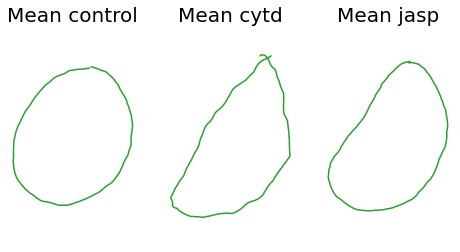

In [49]:
fig = plt.figure(figsize=(8, 4))
count = 1
for treatment in TREATMENTS:
    mean_cell = mean_treatment_cells[treatment]
    fig.add_subplot(1, len(TREATMENTS), count)
    count += 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C2")
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"Mean {treatment}", fontsize=20)
plt.savefig("cancer_mean_treatment_cells.svg")

In [50]:
mean_line_cells = {}
for line in LINES:
    line_cells = []
    for treatment in TREATMENTS:
        line_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
    mean_estimator.fit(line_cells[:225])
    mean_line_cells[line] = mean_estimator.estimate_

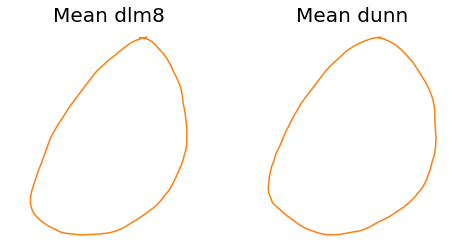

In [51]:
fig = plt.figure(figsize=(8, 4))
count = 1
for line in LINES:
    mean_cell = mean_line_cells[line]
    fig.add_subplot(1, len(LINES), count)
    count += 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C1")
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"Mean {line}", fontsize=20)
plt.savefig("cancer_mean_line_cells.svg")

In [52]:
mean_cells = {}
for treatment in TREATMENTS:
    mean_cells[treatment] = {}
    for line in LINES:
        mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
        mean_estimator.fit(ds_align[treatment][line][:20])
        mean_cells[treatment][line] = mean_estimator.estimate_

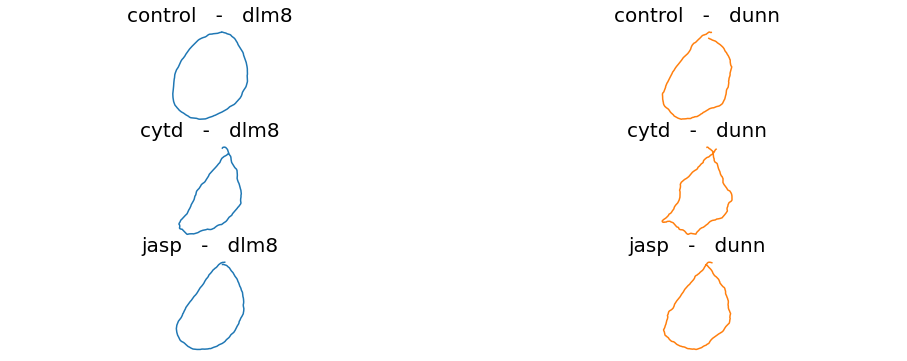

In [53]:
fig = plt.figure(figsize=(16, 6))
count = 1
for treatment in TREATMENTS:
    for j, line in enumerate(LINES):
        mean_cell = mean_cells[treatment][line]
        fig.add_subplot(len(TREATMENTS), len(LINES), count)
        count += 1
        plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{j}")
        plt.axis("equal")
        plt.axis("off")
        plt.title(f"{treatment}   -   {line}", fontsize=20)
plt.savefig("cancer_mean_cells.svg")

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [54]:
dists_to_own_mean = {}
nan_ids = {}
for treatment in TREATMENTS:
    dists_to_own_mean[treatment] = {}
    nan_ids[treatment] = {}
    for line in LINES:
        dists = []
        ids = []
        for i_curve, curve in enumerate(ds_align[treatment][line]):
            one_dist = SRV_METRIC.dist(curve, mean_cells[treatment][line])
            if ~gs.isnan(one_dist):
                dists.append(one_dist)
            else:
                ids.append(i_curve)
        dists_to_own_mean[treatment][line] = dists
        nan_ids[treatment][line] = ids

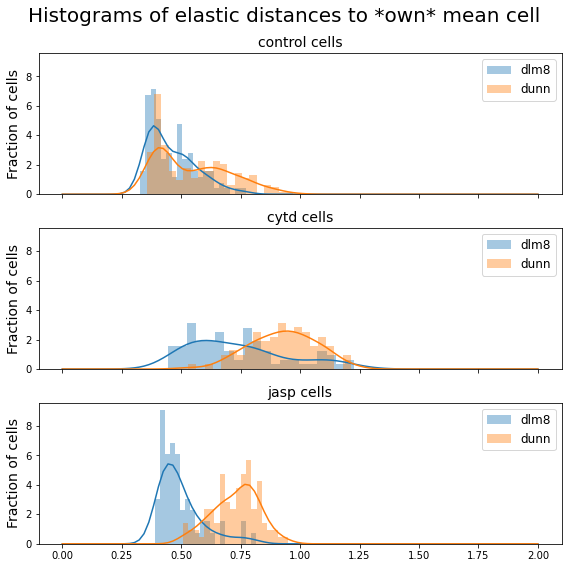

In [55]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = dists_to_own_mean[treatment][line]
        color = f"C{j}"
        axs[i].hist(
            distances, bins=20, alpha=0.4, density=True, color=color, label=line
        )
        kde = stats.gaussian_kde(distances)
        axs[i].plot(xx, kde(xx), color=color)

    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of elastic distances to *own* mean cell", fontsize=20)
plt.savefig("dist_to_own_mean.svg")

Qualitatively, it seems that the control cells and the cells treated with cytd show the most variability in shape. The distributions of distances are more peaked for the cells treated with jasp, which indicates a lower variability in shape. We can hypothesize that the treatment jasp has an effect on the cell's cytoskeleton, in that it will constrain it, closer to its subgroup's mean shape.